In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
start_year = 1975
end_year = 2021

columns = ['IMAGE Region Name', 'time', 'NGFBFC']

In [8]:
def ngfbfc_processing(df):
    try:
        if "type" in df.columns.to_list():
            df = df.rename(columns={"type": "NGFBFC"}) 

        if 'NGFBFC' in df.columns:
            df['NGFBFC'] = df['NGFBFC'].str.lower()
            if 'grass' in df['NGFBFC'].unique():
                df['NGFBFC'] = df['NGFBFC'].replace('grass', 'pasture')
            df['NGFBFC'] = df['NGFBFC'].replace("oil & palm fruit", "palm oil")
            df['NGFBFC'] = df['NGFBFC'].replace("other non-food & luxury & spices", "non food, luxury, spices")
            df['NGFBFC'] = df['NGFBFC'].replace('other temperate cereals', 'temperate cereals')
        return df
    except Exception as e:
        print(f"error: {e}")
        return df

def region_processing(df):
    try:
        df['IMAGE Region Name'] = df['IMAGE Region Name'].replace('Kazakhstan region', 'Central Asia').replace('C. Europe', 'Central Europe').replace('E. Africa', 'Eastern Africa').replace('N. Africa', 'Northern Africa')
        df['IMAGE Region Name'] = df['IMAGE Region Name'].replace('Rest C. America', 'Central America').replace('Rest S. Africa', 'Rest of Southern Africa').replace('Rest S. America', 'Rest of South America')
        df['IMAGE Region Name'] = df['IMAGE Region Name'].replace('Rest S. Asia', 'Rest of South Asia').replace('SE. Asia', 'Southeast Asia').replace('Rest S. America', 'Rest of South America')
        df['IMAGE Region Name'] = df['IMAGE Region Name'].replace('W. Africa', 'Western Africa').replace('W. Europe', 'Western Europe').replace('Russia', 'Russia region')
        df['IMAGE Region Name'] = df['IMAGE Region Name'].replace('Indonesia', 'Indonesia region').replace('China', 'China region').replace('Korea', 'Korea region')
        return df
    except Exception as e:
        print(f"error: {e}")
        return df

def custom_mean(x):
  """Calculates the mean of non-zero values."""
  non_zero_values = x[x > 0]
  return non_zero_values.sum() / len(non_zero_values) if len(non_zero_values) > 0 else 0


def get_top_n(df, category_col, value_col, n=3):
    return df.groupby(category_col).apply(lambda x: x.nlargest(n, value_col)).reset_index(drop=True)

def get_angular_position(NGFBFC_name, NGFBFCs_list):
    """Calculate the angular position of a NGFBFC in the chart"""
    idx = NGFBFCs_list.index(NGFBFC_name)
    return (idx * 360.0 / len(NGFBFCs_list) + 90) % 360

In [14]:
GECH4RI = pd.read_excel("D:/kerja/asisten riset/code v/review/data/GECH4RI_rice_category_annual_gtco2eq.xlsx")
GECO2AB_CH4 = pd.read_excel("D:/kerja/asisten riset/code v/review/data/GECO2AB_crop_category_annual_gtco2eq_CH4_13Jan.xlsx")
GECO2AB_N2O = pd.read_excel("D:/kerja/asisten riset/code v/review/data/GECO2AB_crop_category_annual_gtco2eq_N2O_13Jan.xlsx")
GEC2OLC = pd.read_excel("D:/kerja/asisten riset/code v/review/data/GEN2OLC_crop_category_annual_gtco2eq.xlsx")
GEN2ORE = pd.read_excel("D:/kerja/asisten riset/code v/review/data/GEN2ORE_crop_category_annual_gtco2eq_13Jan.xlsx")
GFERTYN = pd.read_excel("D:/kerja/asisten riset/code v/review/data/GFERTSYN_crop_category_annual_gtco2eq.xlsx")
GMANURE = pd.read_excel("D:/kerja/asisten riset/code v/review/data/GMANURE_crop_category_annual_gtco2eq.xlsx")
LUC_total = pd.read_excel("D:/kerja/asisten riset/code v/review/data/LUC_total_crop_category_annual_gtco2eq.xlsx")
peat_CH4 = pd.read_excel("D:/kerja/asisten riset/code v/review/data/peat_CH4_crop_category_annual_gtco2eq_v2_13Jan.xlsx")
peat_CO2 = pd.read_excel("D:/kerja/asisten riset/code v/review/data/peat_CO2_crop_category_annual_gtco2eq_v2_13Jan.xlsx")
peat_DOC = pd.read_excel("D:/kerja/asisten riset/code v/review/data/peat_DOC_crop_category_annual_gtco2eq_v2_13Jan.xlsx")
peat_N2O = pd.read_excel("D:/kerja/asisten riset/code v/review/data/peat_N2O_crop_category_annual_gtco2eq_v2_13Jan.xlsx")
country_code = pd.read_excel("D:/kerja/asisten riset/vol/milkunC/achaidir/LUH2 2022/ISO-3166-Country-Code_Final.xlsx", engine="openpyxl")

GECH4RI = ngfbfc_processing(GECH4RI)
GECO2AB_CH4 = ngfbfc_processing(GECO2AB_CH4)
GECO2AB_N2O = ngfbfc_processing(GECO2AB_N2O)
GEC2OLC = ngfbfc_processing(GEC2OLC)
GEN2ORE = ngfbfc_processing(GEN2ORE)
GFERTYN = ngfbfc_processing(GFERTYN)
GMANURE = ngfbfc_processing(GMANURE)
LUC_total = ngfbfc_processing(LUC_total)

peat_CH4 = ngfbfc_processing(peat_CH4)
peat_CO2 = ngfbfc_processing(peat_CO2)
peat_DOC = ngfbfc_processing(peat_DOC)
peat_N2O = ngfbfc_processing(peat_N2O)

all_sources = pd.concat([LUC_total, GEC2OLC, GECH4RI, GECO2AB_CH4, GECO2AB_N2O, GEN2ORE, GFERTYN, GMANURE, peat_CH4, peat_CO2, peat_DOC, peat_N2O], ignore_index=True)
all_sources = all_sources.copy()
all_sources.loc[:, range(start_year, end_year, 5)] = all_sources[range(start_year, end_year, 5)].values * 5

all_sources.rename(columns={'emissions': 'Process'}, inplace=True)
all_sources['Process'] = all_sources['Process'].str.replace("peat_DOC", 'peat_CO2')

all_sources_group = all_sources.groupby(['IMAGE Region Name', 'NGFBFC']).sum()
all_sources_group = all_sources_group.reset_index()
all_sources_group = region_processing(all_sources_group)
all_sources_group = ngfbfc_processing(all_sources_group)
all_sources_group = all_sources_group[all_sources_group['NGFBFC'] != 'pasture']

all_sources_group_copy = all_sources_group.copy()
all_sources_group_copy.loc[:, range(start_year, end_year, 5)] = all_sources_group_copy[range(start_year, end_year, 5)].values * 1e3

all_sources_group_copy['IMAGE Realtion'] =  all_sources_group_copy['NGFBFC'] + " - "  + all_sources_group_copy['IMAGE Region Name']

all_sources_group_copy = all_sources_group_copy[list(range(start_year, end_year, 5)) + ['IMAGE Realtion']]

df_crops = all_sources_group_copy.melt(id_vars=['IMAGE Realtion'], var_name='Time', value_name='value')
df_crops = df_crops[df_crops['IMAGE Realtion'] != 'wheat - Rest of South Asia']

results_crops = {}

df_crops_sort = df_crops.sort_values(by=['value'], ascending=[True])

for time in df_crops_sort['Time'].unique():
    filtered_data = df_crops_sort[df_crops_sort['Time'] == time]
    sorted_data = filtered_data.sort_values(by='value', ascending=False)
    top_5_data = sorted_data.head(3)
    if time not in results_crops:
        results_crops[time] = {}
    results_crops[time] = top_5_data

df_crops_concat = pd.concat([pd.concat(results_crops.values())])

df_crops_copy = df_crops.copy()

time_map = {}
for n in range(start_year, end_year, 5):
    n_awal = n - 5
    time_map[n] = f'{str(n_awal)[2:]}-{str(n)[2:]}'

df_crops_concat_copy = df_crops_concat.copy()
df_crops_concat_copy['Time'] = df_crops_concat_copy['Time'].map(time_map)

df_crops_concat_copy_sorted = df_crops_concat_copy.sort_values(by=['Time', 'value'], ascending=[False, False])

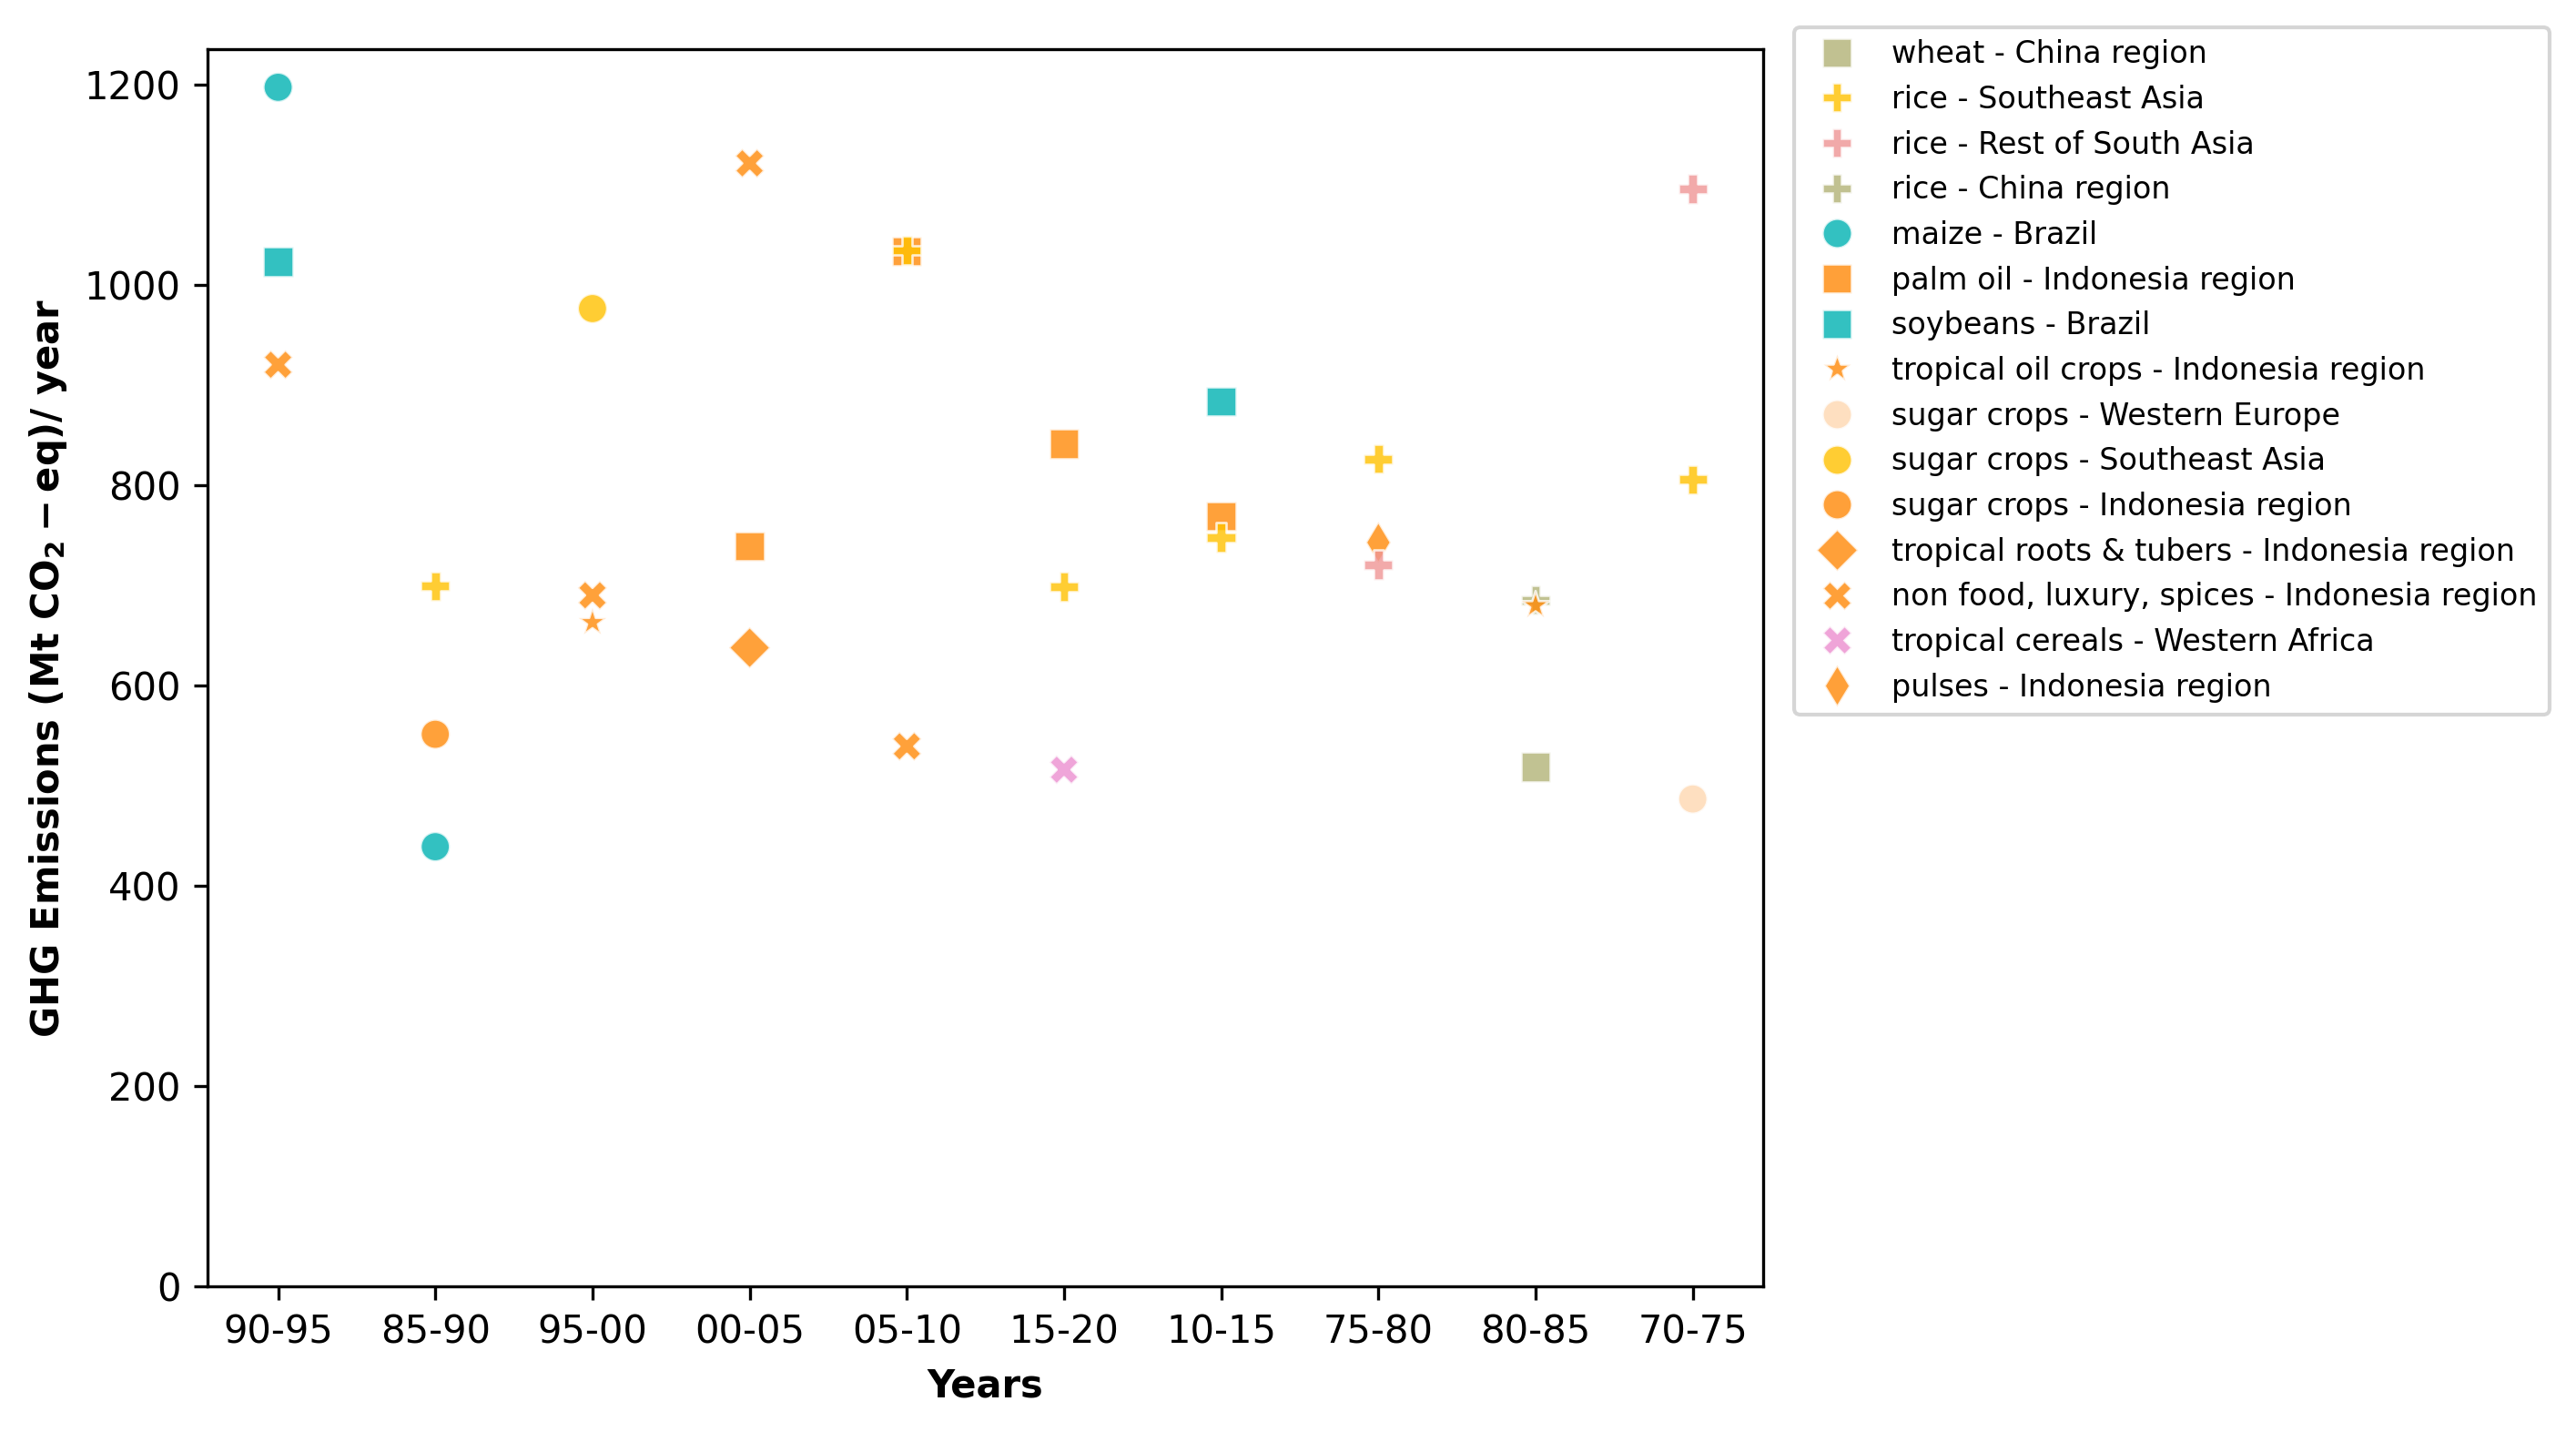

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import seaborn as sns

plt.figure(figsize=(25, 6), dpi=300)
loc = plticker.MultipleLocator(base=1)

ax2 = plt.subplot(131)
ax2.set_ylabel(r"$\bf{GHG\ Emissions\ (Mt~CO_2-eq)/\ year}$", fontsize=10)
ax2.set_xlabel('Years',fontweight='bold', fontsize=10)

sns.scatterplot(x="Time", y="value", color='#DDDDDD',
                sizes=(100, 300), alpha=.3, data=df_crops_copy)

palette = {
    'maize - Brazil': "#00b2b2", 'soybeans - Brazil': "#00b2b2", 'pulses - Brazil': "#00b2b2",
    'wheat - China region': "#B2B377", 'rice - China region': "#B2B377", 'vegetables & fruits - China region': "#B2B377",
    'non food, luxury, spices - Indonesia region': "#FF8A08", 'palm oil - Indonesia region': "#FF8A08", 'tropical oil crops - Indonesia region': "#FF8A08",
    'tropical roots & tubers - Indonesia region':"#FF8A08", 'pulses - Indonesia region':"#FF8A08", 'sugar crops - Indonesia region':"#FF8A08",
    'soybeans - Rest of South America': "#254336",
    'rice - Rest of South Asia': "#EF9595",'wheat - Rest of South Asia': "#EF9595",
    'rice - India': "#EFB495",
    'rice - Southeast Asia': "#FFC100", 'tropical oil crops - Southeast Asia': "#FFC100", 'non food, luxury, spices - Southeast Asia': "#FFC100",
     'sugar crops - Southeast Asia': "#FFC100", 
    'tropical cereals - Western Africa': "#EC8FD0", 'tropical roots & tubers - Western Africa': "#EC8FD0",
    'sugar crops - Western Europe': "#FED8B1"
     
}


markers = {
    'rice - China region': "P", 'rice - Rest of South Asia': "P", 'rice - India': "P",'rice - Southeast Asia': "P",
    'palm oil - Indonesia region': 's', 
    'maize - Brazil': 'o', 
    'pulses - Brazil': "P", 'soybeans - Brazil': 's',
    'vegetables & fruits - China region': "P", 
    'wheat - China region': 's', 'wheat - Rest of South Asia': 's',
    'non food, luxury, spices - Indonesia region': 'X', 'non food, luxury, spices - Southeast Asia': 'o', 
    'soybeans - Rest of South America': 'o',
    'tropical oil crops - Southeast Asia': 's','tropical oil crops - Indonesia region': "*",
    'tropical cereals - Western Africa': 'X', 
    'tropical roots & tubers - Western Africa': "P", 'tropical roots & tubers - Indonesia region': "D",
    'sugar crops - Western Europe': 'o', 'sugar crops - Southeast Asia': 'o', 'sugar crops - Indonesia region' : 'o',
    'pulses - Indonesia region':"d"
}

legend_order = [
    'wheat - China region',
    'rice - Southeast Asia','rice - Rest of South Asia','rice - China region',
    'maize - Brazil',
    'palm oil - Indonesia region',
    'soybeans - Brazil', 
    'tropical oil crops - Indonesia region', 
    'sugar crops - Western Europe','sugar crops - Southeast Asia','sugar crops - Indonesia region', 
    'tropical roots & tubers - Indonesia region',
    'non food, luxury, spices - Indonesia region',
    'tropical cereals - Western Africa',
    'pulses - Indonesia region',
       ]

sns.scatterplot(x="Time", y="value", hue='IMAGE Realtion',alpha=.8, palette=palette, 
                style='IMAGE Realtion', markers=markers, s=60, 
                data=df_crops_concat_copy_sorted.sort_values(by=['IMAGE Realtion'], ascending=[True]), hue_order=legend_order)

ax2.legend(loc='lower left', bbox_to_anchor= (1.01, 0.45), ncol=1, prop={'size': 8})
ax2.xaxis.set_major_locator(loc)
ax2.set_ylim(ymin=0)
plt.show()